# ARIMA

In [1]:
import itertools
import tqdm
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


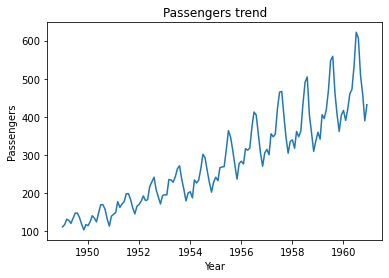

In [2]:
data = pd.read_csv("AirPassengers.csv", 
                   index_col="Month", 
                   parse_dates=True, 
                   )

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(data["#Passengers"])

ax1.set_title("Passengers trend")
ax1.set_xlabel("Year")
ax1.set_ylabel("Passengers")

plt.show()

In [3]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


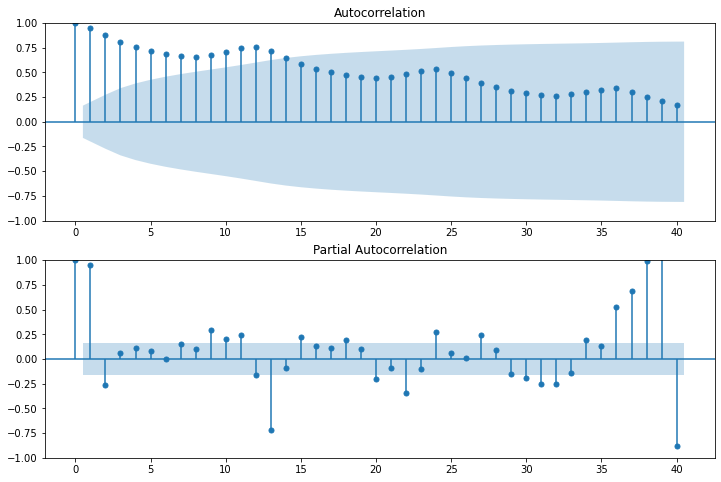

In [4]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax2)

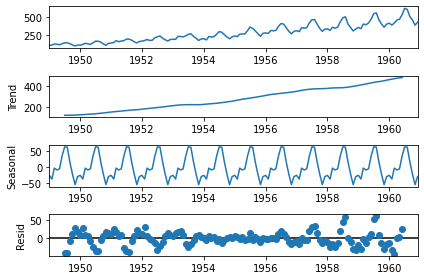

In [5]:
seasonal_decompose_res = sm.tsa.seasonal_decompose(data)
_ = seasonal_decompose_res.plot()

In [54]:
train = data.loc[:"1957-12-31", "#Passengers"].copy()
train.index = pd.DatetimeIndex(train.index).to_period('M')
for i in range(2): #0次と1次の和分過程で探索
    delta_y = np.diff(train, n=i)
    resdiff = sm.tsa.arma_order_select_ic(delta_y, ic="aic", trend="c")
    print(resdiff)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'aic':              0            1            2
0  1270.549515  1143.916187  1114.859235
1  1015.446107  1002.262358  1001.828797
2  1006.850149  1000.565534  1001.223951
3  1004.170932  1001.513941  1003.223933
4  1005.734655  1002.544020   997.307343, 'aic_min_order': (4, 2)}


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'aic':              0           1           2
0  1002.825967  991.645833  989.103484
1   996.373214  988.670394  971.486567
2   991.748806  969.042260  973.478864
3   992.647446  970.847890  966.633469
4   982.346748  984.184915  965.811318, 'aic_min_order': (4, 2)}


In [55]:
model_final = sm.tsa.ARIMA(
    train, order = (4,1,2), trend="t"
)
results = model_final.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  108
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -474.904
Date:                Sun, 10 Jul 2022   AIC                            965.809
Time:                        08:39:23   BIC                            987.191
Sample:                    01-31-1949   HQIC                           974.477
                         - 12-31-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5411      0.312      8.136      0.000       1.929       3.153
ar.L1          0.1979      0.116      1.714      0.087      -0.028       0.424
ar.L2          0.3669      0.141      2.603      0.0

In [56]:
ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(results.resid, lags=10)
ljungbox_result

,lb_stat,lb_pvalue
1,0.000013,0.997124
2,0.002439,0.998781
3,0.264743,0.966517
4,1.175369,0.882137
5,1.194796,0.945376
6,2.567585,0.860828
7,2.787184,0.903967
8,4.710692,0.788003
9,4.710949,0.858743
10,6.615309,0.761194


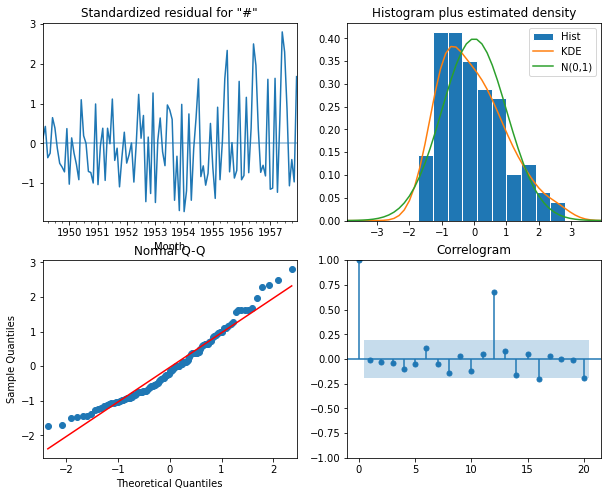

In [57]:
_ = results.plot_diagnostics(figsize=(10,8), lags=20)

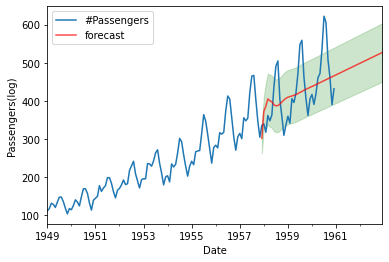

In [58]:
pred = results.get_prediction(start=pd.to_datetime("1957-12-01"),
                              end = pd.to_datetime("1962-12-01"),
                              dynamic=False)

# 期待値と信頼区間を取り出す
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha = .05)

# グラフの描画
data["1949-01-01":].plot(label="observed")
pred_mean.plot(label="forecast", alpha=.7, color = "r")
 
# 信頼区間の描画
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='g', alpha=.2)
 
plt.xlabel("Date")
plt.ylabel("Passengers(log)")
plt.legend()